# Learn from started codes

* <u>Motivation</u>

As a chess player (♟♞ ELO ± 1,600) and data scientist (R pseudo expert), this AI Blitz caught my interest! But my expertise on image/video analysis is weak. Although I know the theory of neural network, I never have the chance to practice.

Could this challenge be a **first introduction** ?

--> Thanks to baseline scripts shared by the admin (big thank you to 👍 @Ashivani 👍), the answer is **yes**.


* <u>Context</u>

A) 3 of the 5 challenges are about **image binary classification**. From a chessboard picture, we would like to estimate which player (black or white):
  1. have more pieces?
  2. have more points?
  3. is the winner?

B) One challenge is about **image transcription**: describe FEN notation from a chessboard image. 

C) The last one is about **video transcription**: descrive piece moves from a short video.

* <u>AICrowd connexion</u> 🔌


In [ ]:
!pip install --upgrade fastai git+https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli.git >/dev/null
%load_ext aicrowd.magic
API_KEY = '80f5b4c15de2bb95c6ef8b4dbf9264d8'
%aicrowd login --api-key $API_KEY

  Running command git clone -q https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli.git /tmp/pip-req-build-_xj5xdqu
API Key valid
Saved API Key successfully!


# A) Image binary classification

For this king of problem, a starting solution is to used a **pre-trained model**. Even if it was not trained with chess pictures, its previous learnings could be robust enough for other problems. As chess pictures of these challenges are quite clean (similar size, easily readible, etc.), it could work without specifically building new layer. 

The baseline propose to use AlexNet, a Convolutional Neural Network (CNN) designed for classify images. Let's see what it will done on these chess pictures.

### Import Packages 📦

In [ ]:
import pandas as pd
from fastai.vision.all import *
from fastai.data.core import *
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


### Access Data ♚♕♜♘♝♙

We start by downloading the zipfile, and unzip them. Let's start with the first challenge (Pieces).

* <u>Pieces</u>

In [ ]:
%aicrowd dataset download --challenge chess-pieces -j 3

In [ ]:
!rm -rf data
!mkdir data
!mkdir data/pieces

!unzip train.zip  -d data/pieces/ 
!unzip val.zip -d data/pieces/ 
!unzip test.zip  -d data/pieces/

In [ ]:
!mv train.csv data/pieces/train.csv
!mv val.csv data/pieces/val.csv
!mv sample_submission.csv data/pieces/sample_submission.csv

We can visualize a summary table, containing image names and labels.

In [ ]:
train_df = pd.read_csv("data/pieces/train.csv")
train_df['ImageID'] = train_df['ImageID'].astype(str)+".jpg"
train_df

ImageID  label
0          0.jpg  black
1          1.jpg  white
2          2.jpg  black
3          3.jpg  black
4          4.jpg  black
...          ...    ...
39995  39995.jpg  black
39996  39996.jpg  white
39997  39997.jpg  black
39998  39998.jpg  white
39999  39999.jpg  white

[40000 rows x 2 columns]

We can also visualise some training images (chessboard with label)

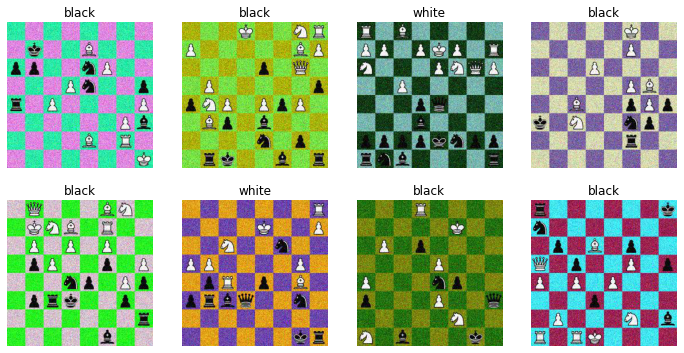

In [ ]:
dls = ImageDataLoaders.from_df(train_df, path="data/pieces/train", bs=8)
dls.show_batch()

### Pre-trained model 💪

In [ ]:
learn = cnn_learner(dls, alexnet, metrics = F1Score())
learn.fit(1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


For the 3 image binary classification problem (Pieces, Points and WinPrediction), the accuracy with this model is around **60 %**. As it's my first Python neural network code, I start by playing with it, trying to improve the accuracy.

### Improvments tests 🧪

There are several ways to (try to) improve such a solution:

* Increase number of epochs of the neural network
```
learn.fit(4)
```

* Increase number of training images, by transforming existing ones for instance
```
aug_transforms(do_flip = False)
```

* Test different parameters of the neural network (learning rate for instance)
```
learn.lr_find()
learn.fit_one_cycle(2, lr_max = 1e-3)
```

* Test other pre-trained classifier

### Results 📝

* <u>Pieces</u>

With the different options described above, I managed to increase the accuracy for the first challenge - which players have more pieces - to an unexpected level (**99.99 %** 😜) using the **pre-trained model ResNet-50** and only 3 epochs (see below). There are several participants with a similar performance (and it should increase day after day).

* <u>Points and WinPrediction</u>

With a similar approch, I reached accuracy of 98.8% for Points challenge, and 94% for WinPrediction. Some other participants manage to get better accuracy (close 100 %), meaning there are other improvments I have to do.

At the beginning of the training, accuracy increase with epoch number, but quickly (7-8 epochs) converge, meaning the algorithm will overfit if continue. Other kind of improvment should be explore.

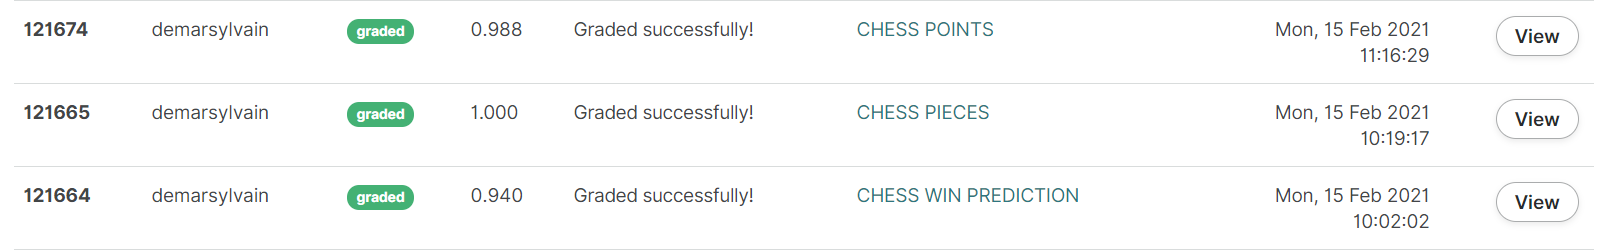

* <u>Code</u>

In [ ]:
dls = ImageDataLoaders.from_df(train_df, path="data/pieces/train", bs=8)
learn = cnn_learner(dls, models.resnet50, metrics = F1Score())

In [ ]:
learn.fine_tune(3)

### Submission ✉

We can use this solution to predict on the test dataset, and submit on the challenge to be sure our solution has a similar accuracy, and it didn't overfitting the training dataset.

In [ ]:
test_imgs_name = get_image_files("data/pieces/test")
test_dls = dls.test_dl(test_imgs_name)
label_to_class_mapping = {v: k for v, k in enumerate(dls.vocab)}
test_img_ids = [re.sub(r"\D", "", str(img_name)) for img_name in test_imgs_name]
_,_,results = learn.get_preds(dl = test_dls, with_decoded = True)
results = [label_to_class_mapping[i] for i in results.numpy()]

In [ ]:
submission = pd.DataFrame({"ImageID":test_img_ids, "label":results})
submission.to_csv("submission.csv", index=False)
%aicrowd submission create -c chess-pieces -f submission.csv

# B) Image transcription

*(on going)*

### Import Packages 📦

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform
import keras
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

### Access Data ♚♕♜♘♝♙

In [ ]:
%aicrowd dataset download --challenge chess-configuration -j 3

!mkdir data
#!unzip train.zip  -d data/config/ 
#!unzip val.zip -d data/config/ 
!unzip test.zip  -d data/config/ 

!mv train.zip data/config/train.zip
!mv train.csv data/config/train.csv
!mv val.csv data/config/val.csv
!mv val.zip data/config/val.zip
!mv test.zip data/config/test.zip
!mv sample_submission.csv data/config/sample_submission.csv

In [ ]:
train = glob.glob("data/config/train/*.jpg")
test = glob.glob("data/config/test/*.jpg")
train[0]

In [ ]:
train_csv = pd.read_csv("data/config/train.csv")
train_csv['ImageID'] = train_csv['ImageID'].astype(str)+".jpg"
train_csv

ImageID                                              label
0          0.jpg  1rbqkb1r/p1p1n1pp/1pn1p3/1P1p1p2/3P4/N3B2P/P1P...
1          1.jpg          2bk4/2q1p3/3p3P/5r2/r5nP/P2K2N1/8/2q1NB1R
2          2.jpg  3rnq2/3k1p2/5rP1/pppp1P2/P1BP2P1/RPP1K2N/3B3P/...
3          3.jpg  r4br1/1p2ppp1/3k2Pp/p2P3n/2pP1N2/P1P1K3/nP5P/1...
4          4.jpg     4kn2/8/p6b/1p6/P1p1p1pr/1P2P1N1/1R1r3P/1K2R1N1
...          ...                                                ...
39995  39995.jpg                r7/B6k/2pp1bpP/8/1p6/1P3P2/5N2/5KRB
39996  39996.jpg  r5B1/1b2k1b1/4Npp1/p3P3/P2p1P2/1R2P3/2P2KqP/1Q...
39997  39997.jpg          6n1/k7/1pP5/1P1pP1n1/p4PBP/R6b/2Kb4/3N2R1
39998  39998.jpg  r1b1qk2/3n4/1pp1nb2/p3p1Nr/2p3Pp/PP2P2P/R2PBP1...
39999  39999.jpg           1r1n3r/p3k3/P7/2p1P3/1P3p1p/7P/2K2R2/3Q4

[40000 rows x 2 columns]

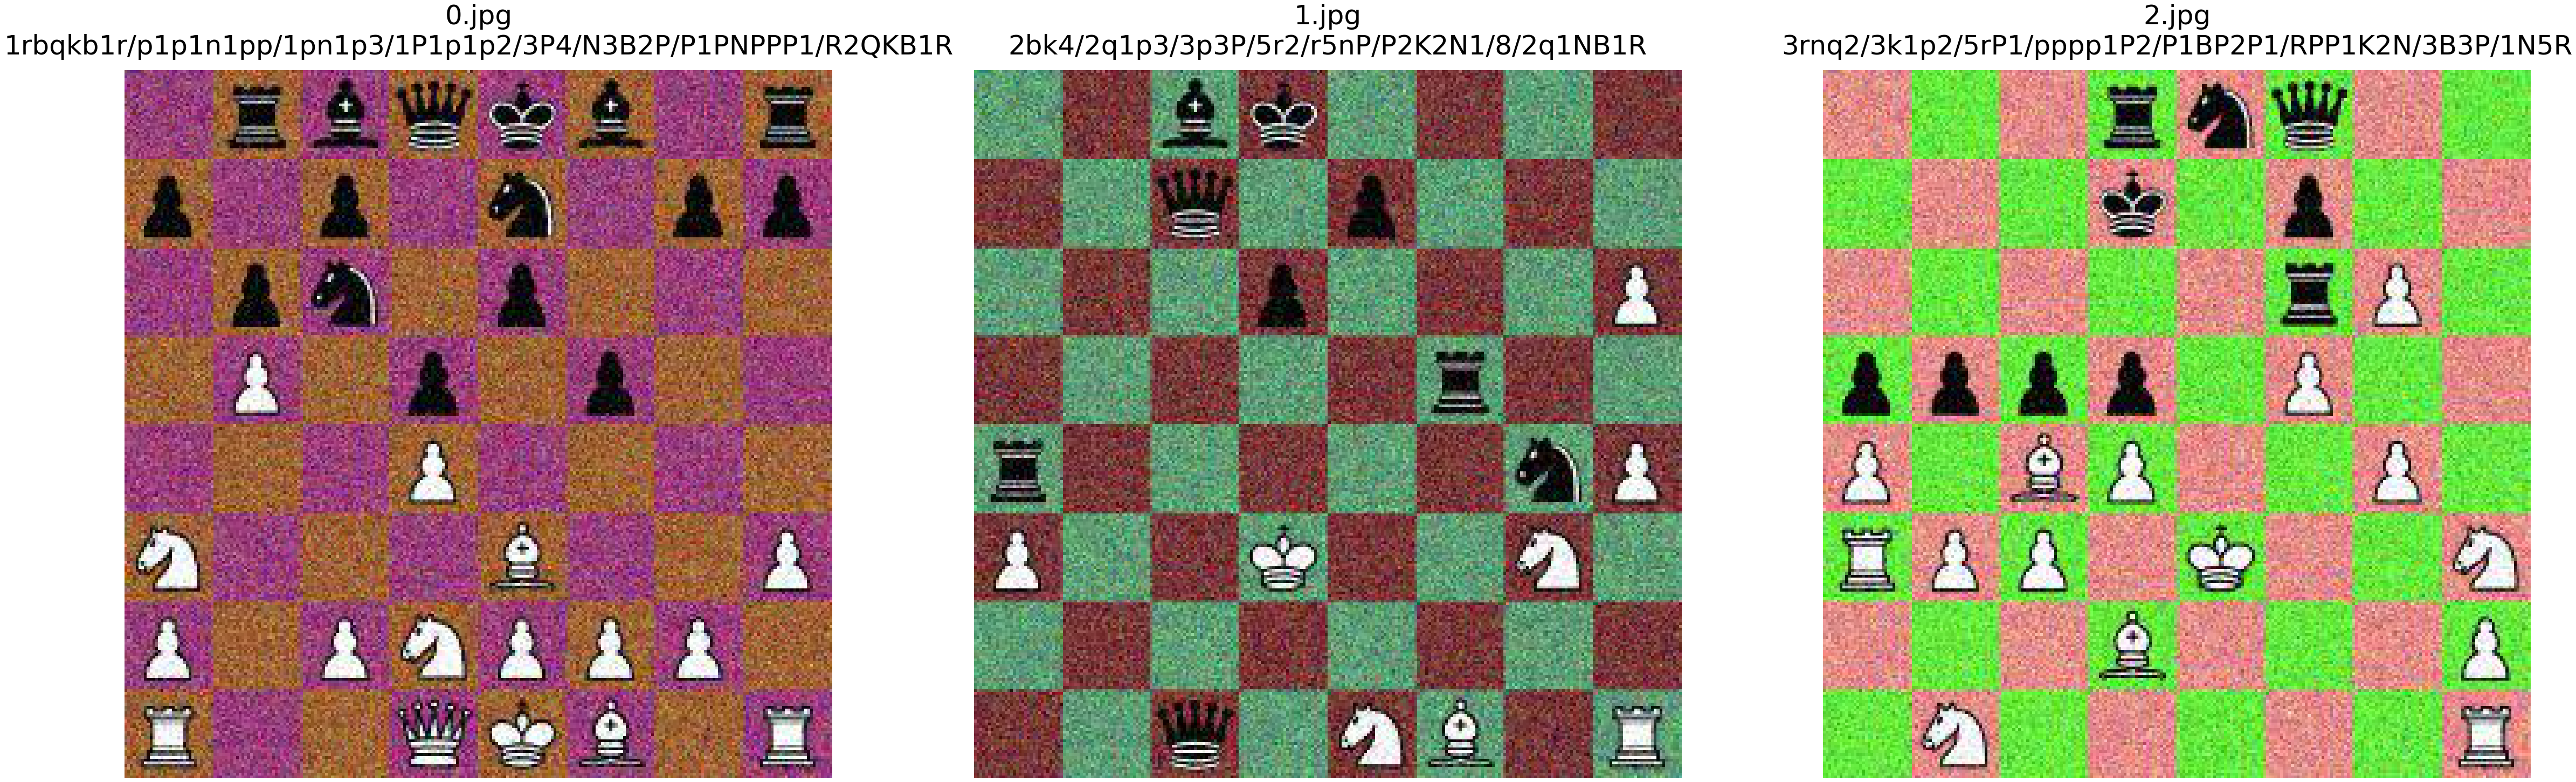

In [ ]:
f, axarr = plt.subplots(1,3, figsize=(80, 80))

for i in range(0,3):
    axarr[i].set_title(train_csv['ImageID'][i] +  '\n' + train_csv['label'][i], fontsize=50, pad=30)
    axarr[i].imshow(mpimg.imread('data/config/train/' + train_csv['ImageID'][i]))
    axarr[i].axis('off')

### Pre-trained model

Pre-trained classifiers (AlexNet, ResNet-50, etc.) will not work here, as there are unlimited label possibilities, it's not "black" or "white" as before. We need another kind of algorithm.




### Existing Kaggle 🏅

It's not a pre-trained model, but some [solutions](https://www.kaggle.com/koryakinp/chess-fen-generator) have already been built for this FEN Notation problem, during a Kaggle competition. I will try to replicate it. 

The aim of the solution is to:
* split the chessboard image into 64 smaller images, each one corresponding to a case of the chessboard
* identify if the case contains a piece or not
* if yes, identify which one
* finally, transform the insight results into the FEN Notation.

Finally, this will bring back us to a classifier model, as we will try to predict, for each case, which piece is present (empty included, meaning 13 classes).


In order to replicate this solution, we have to definie some functions, one to transform the FEN Notation into 13 binary variables (12 for the black and white unique pieces and 1 for empty case).

In [ ]:
piece_symbols = 'prbnkqPRBNKQ'

In [ ]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[/]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

In [ ]:
def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '/'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

# - adjust function, for fun only
def fen_from_onehot2(one_hot):
    output = ''
    for j in range(64):
        if(j%8 == 0 and j != 0):
            output += '/'
        if(np.where(one_hot[j])[0][0] == 12):
            output += ' '
        else:
            output += piece_symbols[np.where(one_hot[j])[0][0]]

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [ ]:
fen_from_onehot2(onehot_from_fen('8/b6R/5b2/3R2R1/2p5/r2Kr2k/3N3r/6p1'))

'8/b6R/5b2/3R2R1/2p5/r2Kr2k/3N3r/6p1'

He also built a function to associated the right label with an image name:

In [ ]:
def fen_from_filename(filename):
  base = os.path.basename(filename)
  number = int(os.path.splitext(base)[0])
  return train_csv['label'][number]

#print(fen_from_filename(train[0]))

He also built a function to reshape image

In [ ]:
def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

In [ ]:
process_image('data/config/train/10.jpg')

And a last function for sampling batch during training:

In [ ]:
def train_gen(features, labels, batch_size):
    for i, img in enumerate(features):
        y = onehot_from_fen(fen_from_filename(img))
        x = process_image(img)
        yield x, y

def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

He finally built his own neural network

In [ ]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(25, 25, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(13))
model.add(Activation('softmax'))
model.compile(
  loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit_generator(train_gen(train, None, 64), steps_per_epoch=40000)

40000/40000 [==============================] - 680s 17ms/step - loss: 0.0126 - accuracy: 0.9972


In [ ]:
# serialize model to JSON
FEN_model_json = model.to_json()
with open("FEN_model.json", "w") as json_file:
    json_file.write(FEN_model_json)
# serialize weights to HDF5
model.save_weights("FEN_model.h5")
print("Saved FEN model to disk")

In [ ]:
# load json and create model
json_file = open('FEN_model40.json', 'r')
model_json = json_file.read()
json_file.close()
model = keras.models.model_from_json(model_json)
# load weights into new model
model.load_weights("FEN_model40.h5")
print("Loaded FEN model from disk")

Loaded FEN model from disk


When the model is trained, we can apply it on test dataset

In [ ]:
test = glob.glob("data/config/test/*.jpg")

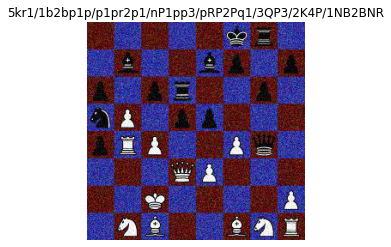

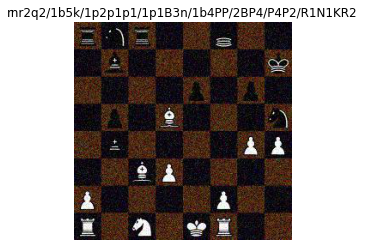

In [ ]:
def display_with_predicted_fen(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

display_with_predicted_fen(test[0])
display_with_predicted_fen('data/config/test/7206.jpg')

### Performance

In [ ]:
train_img = [f'data/config/train/{i}' for i in train_csv.ImageID]

train_config = (
  model.predict_generator(pred_gen(train_img, 64), steps=40000)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

In [ ]:
train_pred = np.array([fen_from_onehot(one_hot) for one_hot in train_config])
train_csv['config'] = train_pred
train_csv.to_csv("data/config/train_with_pred.csv", index=False)
train_csv 

ImageID  ...                                             config
0          0.jpg  ...  1rbqkb1r/p1p1n1pp/1pn1p3/1P1p1p2/3P4/N3B2P/P1P...
1          1.jpg  ...          2bk4/2q1p3/3p3P/5r2/r5nP/P2K2N1/8/2q1NB1R
2          2.jpg  ...  3rnq2/3k1p2/5rP1/pppp1P2/P1BP2P1/RPP1K2N/3B3P/...
3          3.jpg  ...  r4br1/1p2ppp1/3k2Pp/p2P3n/2pP1N2/P1P1K3/nP5P/1...
4          4.jpg  ...     4kn2/8/p6b/1p6/P1p1p1pr/1P2P1N1/1R1r3P/1K2R1N1
...          ...  ...                                                ...
39995  39995.jpg  ...                r7/B6k/2pp1bpP/8/1p6/1P3P2/5N2/5KRB
39996  39996.jpg  ...  r5B1/1b2k1b1/4Npp1/p3P3/P2p1P2/1R2P3/2P2KqP/1Q...
39997  39997.jpg  ...          6n1/k7/1pP5/1P1pP1n1/p4PBP/R6b/2Kb4/3N2R1
39998  39998.jpg  ...  r1b1qk2/3n4/1pp1nb2/p3p1Nr/2p3Pp/PP2P2P/R2PBP1...
39999  39999.jpg  ...           1r1n3r/p3k3/P7/2p1P3/1P3p1p/7P/2K2R2/3Q4

[40000 rows x 3 columns]

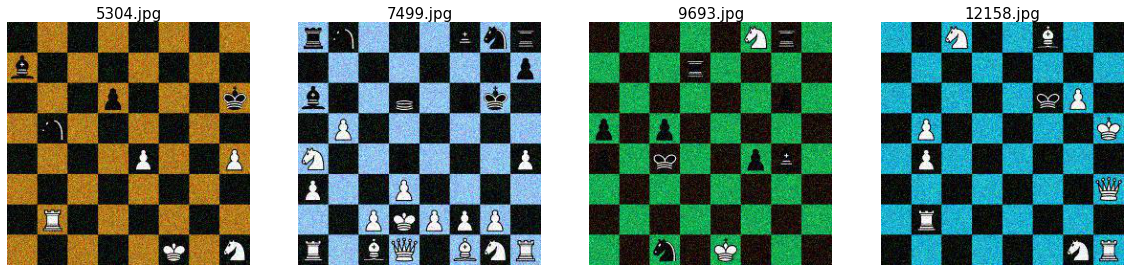

In [ ]:
f, axarr = plt.subplots(1,4, figsize=(20, 20))
ids = [5304, 7499, 9693, 12158]

for i in range(4):
    axarr[i].set_title(train_csv['ImageID'][ids[i]], fontsize=15, pad=3)
    axarr[i].imshow(mpimg.imread('data/config/train/' + train_csv['ImageID'][ids[i]]))
    axarr[i].axis('off')

In [ ]:
check = []
for i in range(train_csv.shape[0]):
  check.append(1 * train_csv['label'][i] == train_csv['config'][i])

train_csv['check'] = check
train_error = train_csv[train_csv['check'] == False]
train_error

ImageID  ...  check
5304    5304.jpg  ...  False
7499    7499.jpg  ...  False
9693    9693.jpg  ...  False
12158  12158.jpg  ...  False
12615  12615.jpg  ...  False
12830  12830.jpg  ...  False
15130  15130.jpg  ...  False
15772  15772.jpg  ...  False
15847  15847.jpg  ...  False
16760  16760.jpg  ...  False
17373  17373.jpg  ...  False
18040  18040.jpg  ...  False
22319  22319.jpg  ...  False
25977  25977.jpg  ...  False
29038  29038.jpg  ...  False
30869  30869.jpg  ...  False
32876  32876.jpg  ...  False
36356  36356.jpg  ...  False
37888  37888.jpg  ...  False

[19 rows x 4 columns]

We will try to increase contrast for some images.

In [ ]:
from PIL import Image, ImageEnhance

In [ ]:
from PIL import Image, ImageEnhance

#read the image
im = Image.open("data/config/train/5304.jpg")

#image brightness enhancer
enhancer = ImageEnhance.Contrast(im)

factor = 1 #gives original image
im_output = enhancer.enhance(factor)
im_output.save('original-image.png')

factor = 0.5 #decrease constrast
im_output = enhancer.enhance(factor)
im_output.save('less-contrast-image.png')

factor = 1.5 #increase contrast
im_output = enhancer.enhance(factor)
im_output.save('more-contrast-image.png')

f, axarr = plt.subplots(1,3, figsize=(20, 20))
axarr[0].imshow(mpimg.imread('original-image.png'))
axarr[1].imshow(mpimg.imread('less-contrast-image.png'))
axarr[2].imshow(mpimg.imread('more-contrast-image.png'))

In [ ]:
f, axarr = plt.subplots(1,3, figsize=(20, 20))
axarr[0].imshow(mpimg.imread('original-image.png'))
axarr[1].imshow(mpimg.imread('less-contrast-image.png'))
axarr[2].imshow(mpimg.imread('more-contrast-image.png'))

1n1k1b2/r3pr2/1p1pPR2/p6N/8/1p4P1/P3KNB1/4R3


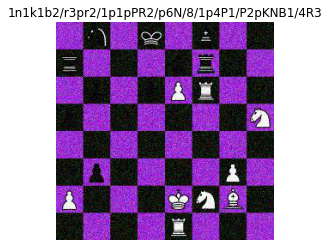

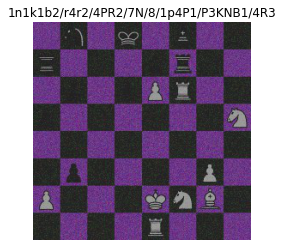

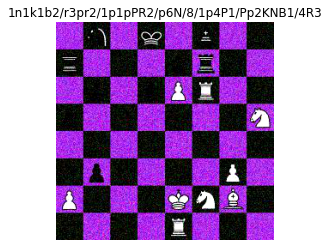

In [ ]:
i = 37888
print(train_csv['label'][i])
im = Image.open("data/config/train/" + str(i) + ".jpg")
enhancer = ImageEnhance.Contrast(im)
im_output = enhancer.enhance(1)
im_output.save('original-image.png')
im_output = enhancer.enhance(.5)
im_output.save('less-contrast-image.png')
im_output = enhancer.enhance(1.2)
im_output.save('more-contrast-image.png')
display_with_predicted_fen('original-image.png')
display_with_predicted_fen('less-contrast-image.png')
display_with_predicted_fen('more-contrast-image.png')

### Submission ✉

In [ ]:
submission = pd.read_csv("data/config/sample_submission.csv")
test = [f'data/config/test/{i}.jpg' for i in submission.ImageID]

onehots = (FEN_model.predict_generator(pred_gen(test, 64), steps=10000).argmax(axis=1).reshape(-1, 8, 8))

In [ ]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in onehots])
pred_fens

array(['7r/2k1n2b/p6P/P7/4P3/N6P/r7/3K2q1',
       'b1r5/prpk1p1p/1p2p2P/6R1/P1nP2q1/1P2P3/2PK1P2/R3N2B',
       '1r1qk2r/1pp5/p2p2pN/4p3/5p2/bb1PBPP1/1Pn1PNBP/RQ1K1R2', ...,
       'rn2r3/p2p1p1k/b2b4/2p1pp2/1qN1P2n/P2PKP1P/8/R1B4R',
       '8/pq1n1p1r/1k1p3n/5P2/1Pr4P/1R2P2P/R2P1Q2/2BK4',
       'rn1krb2/3p1p1p/pp4P1/2p1p3/2PP2P1/PPB2QP1/3PK3/RN3BNR'],
      dtype='<U63')

In [ ]:
submission['label'] = pred_fens
submission.to_csv("data/config/config_submission.csv", index=False)
#%aicrowd submission create -c chess-configuration -f data/config/config_submission.csv
#submission

In [ ]:
%aicrowd submission create -c chess-configuration -f data/config/config_submission.csv

Output()

                                    ╭─────────────────────────╮                                     
                                    │ Successfully submitted! │                                     
                                    ╰─────────────────────────╯                                     
                                          Important links                                           
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-6/submissions/123860              │
│                  │                                                                               │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-6/submissions?my_submissions=true │
│                  │                                                                               │
│      Leaderboard │ https://www.aicrowd.com/challenges/ai-blitz-6/leaderboards            

## Main color

In [ ]:
from PIL import Image, ImageDraw, ImageEnhance
import argparse
import sys

In [ ]:
def get_colors(image_file, numcolors=10, resize=150):
    # Resize image to speed up processing
    img = Image.open(image_file)
    img = img.copy()
    img.thumbnail((resize, resize))

    # Reduce to palette
    paletted = img.convert('P', palette=Image.ADAPTIVE, colors=numcolors)

    # Find dominant colors
    palette = paletted.getpalette()
    color_counts = sorted(paletted.getcolors(), reverse=True)
    colors = list()
    for i in range(numcolors):
        palette_index = color_counts[i][1]
        dominant_color = palette[palette_index*3:palette_index*3+3]
        colors.append(tuple(dominant_color))

    return colors

In [ ]:
def save_palette(colors, swatchsize=20, outfile="palette.png" ):
    num_colors = len(colors)
    palette = Image.new('RGB', (swatchsize*num_colors, swatchsize))
    draw = ImageDraw.Draw(palette)

    posx = 0
    for color in colors:
        draw.rectangle([posx, 0, posx+swatchsize, swatchsize], fill=color) 
        posx = posx + swatchsize

    del draw
    palette.save(outfile, "PNG")

In [ ]:
colors = get_colors("data/config/test/7206.jpg")
print(colors)

[(75, 35, 19), (9, 5, 13), (17, 12, 19), (74, 44, 25), (79, 52, 30), (22, 14, 20), (11, 11, 17), (53, 32, 20), (37, 17, 17), (144, 137, 130)]


Calculate percentage of black in the image

In [ ]:
test_csv = pd.read_csv("config_submission.csv")

In [ ]:
black_pct = []

for i in range(test_csv.shape[0]):
  if(i % 250 == 0): 
    print(i)
  im = Image.open('data/config/test/' + test_csv['ImageID'][i].astype(str) + '.jpg')
  # - get the pixels as a flattened sequence 
  pixels = im.getdata()
  n = len(pixels) 
  # - count number of black pixel  
  nblack = 0
  for pixel in pixels:
    if sum(pixel) < 50:   # under 50 consider as a black pixel
        nblack += 1
  # - percentage
  black_pct.append(nblack / float(n))


test_csv['black_pct'] = black_pct

In [ ]:
test_csv.to_csv("data/config/config_test_withblack.csv", index=False)
test_csv.sort_values(by=['black_pct'], ascending=False).head(15)

ImageID                                              label  black_pct
7206     7206   rnr2q2/1b5k/4p1p1/1p1B3n/1b4PP/2BP4/P4P2/R1N1KR2   0.327671
5428     5428          1B1r4/3B1n2/1N3p2/P1kP4/N3P2p/4K2P/2pr4/8   0.326260
4842     4842                  2Q5/4kbr1/2R5/4p3/p1pP4/7P/4p2K/8   0.283728
2880     2880   rkn5/3b2r1/p1n5/4p1p1/2B1p2P/1qP1P3/QP4p1/1NB3K1   0.277172
798       798  5b1r/rb1pp1Q1/ppnk1n2/2p2p1P/P3P3/3P1PPR/1PNP4...   0.265671
4540     4540        2r5/1q6/b1p1k1P1/Qpn2p1r/P1P3PP/3pP2N/R6K/8   0.252976
5593     5593      rr6/pb1kb2p/q5p1/P2p2N1/1B1PRPP1/N2R1K2/8/5B2   0.241227
2332     2332             6r1/3rk3/2P5/3p4/2NpnPpp/PR2P3/8/3K1B2   0.224115
5015     5015           2b4k/p2p3p/n2P2pP/6P1/1rp5/KP6/4NR2/b4B2   0.223991
9248     9248  2b2qn1/1ppppk1r/1Qnr1Npp/p5B1/P4pPP/5P2/1PP1PK...   0.219744
152       152  1rb2knr/Np3p2/4pbnp/2qB2P1/2p1P2P/P1PP1RP1/1P1...   0.218690
5751     5751                 4r2k/8/P1N3P1/P4n2/8/RR3P1B/n5KP/8   0.218612
2159     2159             3r4/3k4/N2n4/K2p1pP1/4P2N/7P/r2p4/4n2R   0.218178
4249     4249      rn3b2/5k2/2pp2r1/4p1Pp/1Pp4N/P5n1/1BRP1K2/3b4   0.216876
9135     9135            1R6/2p2kpN/5b2/p1r2p2/P1P2r2/pP6/8/1BK5   0.212366

1B1r4/3B1n2/1N3p2/P1kP4/N3P2p/4K2P/2pr4/8


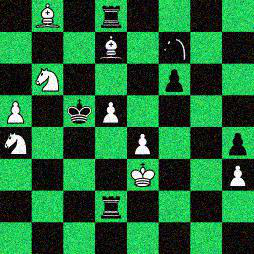

In [ ]:
#!cp data/config/test/5751.jpg data/config/5751.jpg
k = 5428
print(test_csv['label'][k])
Image.open('data/config/test/' + str(k) + '.jpg')

In [ ]:
i = 4842
print(test_csv['label'][i])
im = Image.open("data/config/test/" + str(i) + ".jpg")
enhancer = ImageEnhance.Contrast(im)
im_output = enhancer.enhance(1)
im_output.save('original-image.png')
im_output = enhancer.enhance(.5)
im_output.save('less-contrast-image.png')
im_output = enhancer.enhance(1.2)
im_output.save('more-contrast-image.png')
display_with_predicted_fen('original-image.png')
display_with_predicted_fen('less-contrast-image.png')
display_with_predicted_fen('more-contrast-image.png')

In [ ]:
test_csv['label'][7206] = 'rnr2q2/1b5k/4p1p1/1p1B3n/1b4PP/2BP4/P4P2/R1N1KR2' # ok
test_csv['label'][5428] = '1B1r4/3B1n2/1N3p2/P1kP4/N3P2p/4K2P/3r4/8' # ok, peut-être un en 3e ligne
test_csv['label'][4842] = '2Q5/4kbr1/2R5/4p3/p1pP4/7P/4p2K/8'        # pions vraiment là ?!
test_csv['label'][2880] = 'rkn5/3b2r1/p1n5/4p1p1/2B1p2P/1qP1P3/QP4p1/1NB3K1'
test_csv['label'][5751] = '4r2k/8/P1N3P1/P4n2/8/RR3P1B/n5KP/8'

### New submission

In [ ]:
test_csv.to_csv("data/config/config_submission_withcheck.csv", index=False)

In [ ]:
%aicrowd submission create -c chess-configuration -f data/config/config_submission_withcheck.csv

# C) Video transcription

* <u>Motivation</u>

After playing with the 4 first image puzzles (see my first Notebook [here](https://www.aicrowd.com/showcase/learn-from-started-code), with around 99% accuracy submissions)), it's time to face the last (but not least) puzzle about **video transcription**.

As it's a new field for me, I started some web researches, and here is where I am. One direction I found is to **capture several images from each video**, and analyse these images. 

--> Could this bring back us to **image model?**

--> Could I use the **FEN Notation** transcription model to compare pictures?


* <u> Context </u>

We have access to short video (around 1 seconde) of a chessboard with some moving pieces (around 4-8 moves). The objective is to **translate the moves** from each video.

### Import Packages 📦

In [1]:
!pip install --upgrade fastai git+https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli.git >/dev/null
%load_ext aicrowd.magic
API_KEY = '2a650e9deb734d580b851ac38c3c1036'
%aicrowd login --api-key $API_KEY

  Running command git clone -q https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli.git /tmp/pip-req-build-r757n6am
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
API Key valid
Saved API Key successfully!


In [4]:
## - librairies
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
import string

# for model building
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from skimage import io, transform
from skimage.util.shape import view_as_blocks

### Access Data ♚♕♜♘♝♙

In [ ]:
## - data
%aicrowd dataset download --challenge chess-transcription -j 3

!mkdir video
!unzip train.zip  -d video/ 
#!unzip val.zip -d video/ 
!unzip test.zip  -d video/ 

!mv train.zip video/train.zip
!mv train.csv video/train.csv
!mv val.csv video/val.csv
!mv val.zip video/val.zip
!mv test.zip video/test.zip
!mv sample_submission.csv video/sample_submission.csv

In [16]:
video_df = pd.read_csv("video/train.csv")
video_df['VideoName'] = video_df['VideoID'].astype(str)+".mp4"
video_df

VideoID                                         label VideoName
0           0  e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2     0.mp4
1           1                 c2b3 e1f1 f7e7 a3a4 e7e3 a4a5     1.mp4
2           2  f1c1 h6h7 h4f3 h2g4 f6g6 g4f6 c1g1 f6d7 g6f5     2.mp4
3           3                 h4h5 a7b5 c4b2 d7e6 g1h3 h6f7     3.mp4
4           4                 c6g6 b1c2 g6g5 a2b2 h4f5 e4d3     4.mp4
...       ...                                           ...       ...
4995     4995                 f2e1 b5b8 d1d2 c5c4 d2e2 b8b4  4995.mp4
4996     4996  c7e6 h8b2 d5d4 c4c3 d4e4 c3d2 c8a7 h4g2 b6c6  4996.mp4
4997     4997  g4e5 c5b4 f5b1 b4a5 b6a5 e3e4 g5h4 c4e5 h4g3  4997.mp4
4998     4998       h7h5 h1e1 h8a8 e3d2 e7f7 a4a6 a8f8 e5f7  4998.mp4
4999     4999       c1a1 g5h4 g2h2 d5c4 d2f3 b5b4 e3f4 d8e8  4999.mp4

[5000 rows x 3 columns]

### From video to images 🎥📸

The aim is to transform the video into several images, as I should be easier to analysis these new images than the video itself. Most of the time, a movie contains 24 images per second of video. It could too much for this problem, maybe only 5 images could be enough.

For a starting point, we will try to decompose each video into 2 pictures (stored in a new folder), one at the beginning of the video, and a second at the end. A same label, the one of the original video, will be display for each image associated.

In [6]:
!rm -rf video/train_frame
!mkdir video/train_frame

In [ ]:
for i in tqdm(range(500)):
#for i in tqdm(range(video_df.shape[0])):
  j = i
  count = 0
  videoFile = video_df['VideoName'][j]
  cap = cv2.VideoCapture('video/train/' + videoFile)  # capturing the video from the given path
  frameRate = 1 #cap.get(5)                           # frame rate
  x = 1
  while(cap.isOpened()):
      frameId = cap.get(1)                            # current frame number
      ret, frame = cap.read()
      if (ret != True):
          print ('break')
          break
      if (frameId % math.floor(frameRate) == 0):
          print ('store')
          filename ='video/train_frame/' + videoFile + "_frame%d.jpg" % count;count+=1
          cv2.imwrite(filename, frame)                # storing the frames
  cap.release()

print ("Done!")

Let's have a look at images resulting of the first video: we have now the start and the end view of the video. Could be enough to understand moves? I think so.

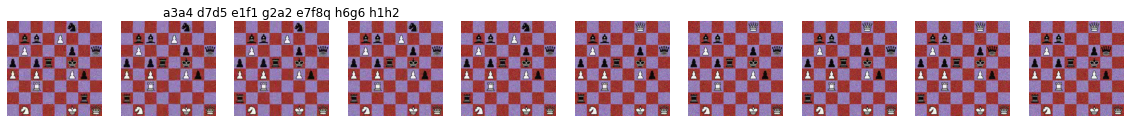

In [20]:
f, axarr = plt.subplots(1,10, figsize=(20, 20))

for i in range(0,10):
  if(i == 2):
    axarr[i].set_title(video_df['label'][9], fontsize=12, pad=5)
  else:
    axarr[i].set_title('')
  axarr[i].imshow(mpimg.imread('video/train_frame/9.mp4_frame' + str(i+12) + '.jpg'))
  axarr[i].axis('off')

In order to associate the right label with the corresponding images, we create a new train dataset.

In [ ]:
# - getting the names of all the images
images = glob("video/train_frame/*.jpg")
video_ID = []
video_name = []
image_name = []
frame_number = []
video_label = []

for i in tqdm(range(len(images))):
    # - creating the image name
    imageName = images[i].split('/')[2]
    image_name.append(imageName)
    # - creating the image label
    videoName = images[i].split('/')[2].split('_')[0]
    video_name.append(videoName)
    videoID = int(videoName.split('.')[0])
    video_ID.append(videoID)
    frameNb = images[i].split('/')[2].split('_')[1].split('.')[0][5:]
    frameNb = int(frameNb)
    frame_number.append(frameNb)
    videoLabel = video_df[video_df['VideoName'] == videoName]['label'].iloc[0]
    video_label.append(videoLabel)

# - storing the images and their class in a dataframe
image_df = pd.DataFrame()
image_df['VideoID'] = video_ID
image_df['VideoName'] = video_name
image_df['frame'] = frame_number
image_df['ImageID'] = image_name
image_df['label'] = video_label

# - converting the dataframe into csv file 
image_df.to_csv('video/image_df.csv', header = True, index = False)

image_df = image_df.sort_values(['VideoID', 'frame'])
image_df.index = range(image_df.shape[0])
image_df

### Apply to test dataset

In [22]:
!rm -rf video/test_frame
!mkdir video/test_frame

In [25]:
video_dftest = pd.read_csv("video/sample_submission.csv")
video_dftest['VideoName'] = video_dftest['VideoID'].astype(str)+".mp4"
video_dftest['label'] = ''
video_dftest

VideoID label VideoName
0           0           0.mp4
1           1           1.mp4
2           2           2.mp4
3           3           3.mp4
4           4           4.mp4
...       ...   ...       ...
1995     1995        1995.mp4
1996     1996        1996.mp4
1997     1997        1997.mp4
1998     1998        1998.mp4
1999     1999        1999.mp4

[2000 rows x 3 columns]

In [ ]:
for i in tqdm(range(video_dftest.shape[0])):
  count = 0
  videoFile = video_dftest['VideoName'][i]
  cap = cv2.VideoCapture('video/test/' + videoFile)  # capturing the video from the given path
  frameRate = 1                                      # frame rate
  x = 1
  while(cap.isOpened()):
      frameId = cap.get(1)                           # current frame number
      ret, frame = cap.read()
      if (ret != True):
          print ('break')
          break
      if (frameId % math.floor(frameRate) == 0):
          print ('store')
          filename ='video/test_frame/' + videoFile + "_frame%d.jpg" % count;count+=1
          cv2.imwrite(filename, frame)               # storing the frames
  cap.release()

print ("Done!")

### Black chessboards

In [27]:
# - getting the names of all the images
images_test = glob("video/test_frame/*.jpg")
video_ID = []
video_name = []
image_name = []
frame_number = []

for i in tqdm(range(len(images_test))):
    # - creating the image name
    imageName = images_test[i].split('/')[2]
    image_name.append(imageName)
    # - creating the image label
    videoName = images_test[i].split('/')[2].split('_')[0]
    video_name.append(videoName)
    videoID = int(videoName.split('.')[0])
    video_ID.append(videoID)
    frameNb = images_test[i].split('/')[2].split('_')[1].split('.')[0][5:]
    frameNb = int(frameNb)
    frame_number.append(frameNb)

# - storing the images and their class in a dataframe
image_dftest = pd.DataFrame()
image_dftest['VideoID'] = video_ID
image_dftest['VideoName'] = video_name
image_dftest['frame'] = frame_number
image_dftest['ImageID'] = image_name

# - converting the dataframe into csv file 
image_dftest.to_csv('video/image_dftest.csv', header = True, index = False)

image_dftest = image_dftest.sort_values(['VideoID', 'frame'])
image_dftest.index = range(image_dftest.shape[0])
image_dftest

100%|██████████| 43910/43910 [00:00<00:00, 271520.21it/s]


VideoID VideoName  frame               ImageID
0            0     0.mp4      0      0.mp4_frame0.jpg
1            0     0.mp4      1      0.mp4_frame1.jpg
2            0     0.mp4      2      0.mp4_frame2.jpg
3            0     0.mp4      3      0.mp4_frame3.jpg
4            0     0.mp4      4      0.mp4_frame4.jpg
...        ...       ...    ...                   ...
43905     1999  1999.mp4     19  1999.mp4_frame19.jpg
43906     1999  1999.mp4     20  1999.mp4_frame20.jpg
43907     1999  1999.mp4     21  1999.mp4_frame21.jpg
43908     1999  1999.mp4     22  1999.mp4_frame22.jpg
43909     1999  1999.mp4     23  1999.mp4_frame23.jpg

[43910 rows x 4 columns]

508.mp4_frame0.jpg


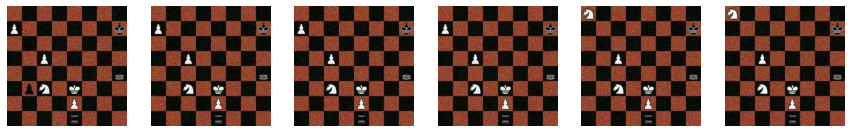

In [29]:
n=6
#image_dftest['ImageID'][11214]
print(image_dftest['ImageID'][11198])
f, axarr = plt.subplots(1,n, figsize=(15, 15))

for i in range(0,n):
  axarr[i].imshow(mpimg.imread('video/test_frame/508.mp4_frame' + str(i+14) + '.jpg'))
  axarr[i].axis('off')

In [30]:
from PIL import Image, ImageDraw, ImageEnhance
import argparse
import sys

In [31]:
image_dftest_0 = image_dftest[image_dftest['frame'] == 0]
#image_dftest_0

In [32]:
black_pct = []

for i in range(image_dftest_0.shape[0]):
  if(i % 250 == 0): 
    print(i)
  im = Image.open('video/test_frame/' + image_dftest_0['ImageID'].values[i])
  # - get the pixels as a flattened sequence 
  pixels = im.getdata()
  n = len(pixels) 
  # - count number of black pixel  
  nblack = 0
  for pixel in pixels:
    if sum(pixel) < 50:   # under 50 consider as a black pixel
        nblack += 1
  # - percentage
  black_pct.append(nblack / float(n))


image_dftest_0['black_pct'] = black_pct

0
250
500
750
1000
1250
1500
1750


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
image_dftest_0.to_csv("video/video_test_withblack.csv", index=False)
image_dftest_0.sort_values(by=['black_pct'], ascending=False).head(15)

VideoID VideoName  frame              ImageID  black_pct
11198      508   508.mp4      0   508.mp4_frame0.jpg   0.369412
11252      510   510.mp4      0   510.mp4_frame0.jpg   0.338877
18959      860   860.mp4      0   860.mp4_frame0.jpg   0.327485
23554     1071  1071.mp4      0  1071.mp4_frame0.jpg   0.241599
24880     1131  1131.mp4      0  1131.mp4_frame0.jpg   0.211110
30356     1386  1386.mp4      0  1386.mp4_frame0.jpg   0.180901
33475     1528  1528.mp4      0  1528.mp4_frame0.jpg   0.173290
23619     1074  1074.mp4      0  1074.mp4_frame0.jpg   0.144135
33194     1515  1515.mp4      0  1515.mp4_frame0.jpg   0.141097
15764      712   712.mp4      0   712.mp4_frame0.jpg   0.135873
20469      929   929.mp4      0   929.mp4_frame0.jpg   0.122295
13480      608   608.mp4      0   608.mp4_frame0.jpg   0.119583
18048      819   819.mp4      0   819.mp4_frame0.jpg   0.118823
30783     1405  1405.mp4      0  1405.mp4_frame0.jpg   0.108981
7384       334   334.mp4      0   334.mp4_frame0.jpg   0.101355

# D) Chess engine?

Stockfish import

In [ ]:
!pip install stockfish

In [ ]:
from stockfish import Stockfish

In [ ]:
stockfish = Stockfish("/Users/zhelyabuzhsky/Work/stockfish/stockfish-9-64")

In [ ]:
stockfish.set_fen_position("rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2")

╭───────────────────── Traceback (most recent call last) ──────────────────────╮
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 │
│ in run_code                                                                  │
│                                                                              │
│   2879 │   │   │   try:                                                      │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                        │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg         │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)     │
│   2883 │   │   │   finally:                                                  │
│   2884 │   │   │   │   # Reset our crash handler in place                    │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                       │
│ <ipython-input-71-ae917cc7b24e>:1 in <module>                                │
╰───────────────────────────

### Chess engine

In [ ]:
import chess
import chess.engine

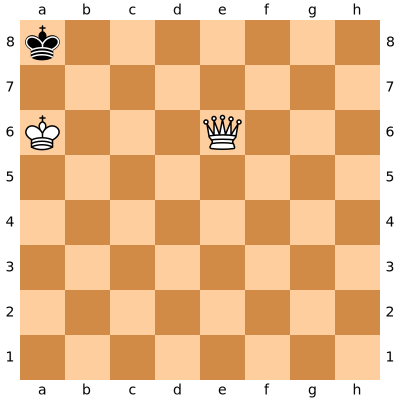

In [ ]:
board = chess.Board('k7/8/K3Q3/8/8/8/8/8 w - - 0 1')
display(board)

In [ ]:
board.is_check()

False

In [ ]:
engine = chess.engine.SimpleEngine.popen_uci("/usr/bin/stockfish")

AttributeError: ignored

In [ ]:
board = chess.Board()
while not board.is_game_over():
    result = engine.play(board, chess.engine.Limit(time=0.1))
    board.push(result.move)

engine.quit()

In [ ]:
#import asyncio
#import chess
#import chess.engine

#async def main() -> None:
#    transport, engine = await chess.engine.popen_uci("/usr/bin/stockfish")

#    board = chess.Board()
#    while not board.is_game_over():
#        result = await engine.play(board, chess.engine.Limit(time=0.1))
#        board.push(result.move)
#
#    await engine.quit()
#
#asyncio.set_event_loop_policy(chess.engine.EventLoopPolicy())
#asyncio.run(main())